# BrainHacks EEG Tutorial

This notebook contains scripts for the Vandy BrainHacks EEG tutorial on January 20, 2024.

Before you run this code, please make sure this .ipynb file is in the same location as a directory called `data`, and that the `MMN_Practice.set` file is in the `data` directory. You should also test the libraries to make sure you have everything installed and that you're loading QT properly; that's important for the functional connectivity visualization.

All of the code in this tutorial is mine, but the datasets are not. The resting-state dataset (which we'll download from openneuro.com) is from:

Hatlestad-Hall, C., Rygvold, T. W., & Andersson, S. (2022). BIDS-structured resting-state electroencephalography (EEG) data extracted from an experimental paradigm. Data in Brief, 45, 108647. https://doi.org/10.1016/j.dib.2022.108647

and the ERP dataset (in the `MMN_Practice.set` file) is from:

Garrido, M. I., Kilner, J. M., Kiebel, S. J., Stephan, K. E., & Friston, K. J. (2007). 
Dynamic causal modelling of evoked potentials: a reproducibility study 
NeuroIma, 1;36(3):571-8 https://doi.org/10.1016/j.neuroimage.2007.03.0140.

We'll start out by importing all the relevant libraries. Much of this functionality is actually contained within MNE itself, but I've included some other things along with it.

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
%matplotlib qt
import numpy as np
import mne
import math
from copy import deepcopy
from meegkit import dss
import fooof
import mne_connectivity as mnec

import openneuro
import os.path as op
import os
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    print_dir_tree,
    make_report,
    find_matching_paths,
    get_entity_vals,
)

We'll be working with two different datasets for this tutorial:
- FG_10011.set -- resting-state data (not publicly available)
- MMN_Practice.set -- ERP data (from CITE)

Both are formatted as EEGLAB `.set` files, so we need the `read_raw_eeglab` function from `mne.io`.

We'll do the resting-state one first, breaking it down step-by-step.

## Stimulus-free analyses

In [2]:
dataset = 'ds003775'
subject = '001'
session = 't1'
datatype = 'eeg'
task = 'resteyesc'
root = './data/openneuro-downloads/%s' % dataset
if not op.exists(root):
    os.mkdir(root)
montage = 'biosemi64'

In [3]:
openneuro.download(dataset=dataset, target_dir=root, include=[f"sub-{subject}"])

In [4]:
rest_path = BIDSPath(
    root=root,
    session=session,
    datatype=datatype,
    subject=subject,
    task=task
)

In [5]:
raw_resting = read_raw_bids(rest_path, verbose=False)
raw_resting.set_montage(montage)
raw_resting.load_data()

Reading 0 ... 245759  =      0.000 ...   239.999 secs...


<RawEDF | sub-001_ses-t1_task-resteyesc_eeg.edf, 64 x 245760 (240.0 s), ~120.1 MB, data loaded>

### Data cleaning

I'd like to look at the power spectrum of this dataset. So let's do that!

Using matplotlib as 2D backend.
Effective window size : 2.000 (s)


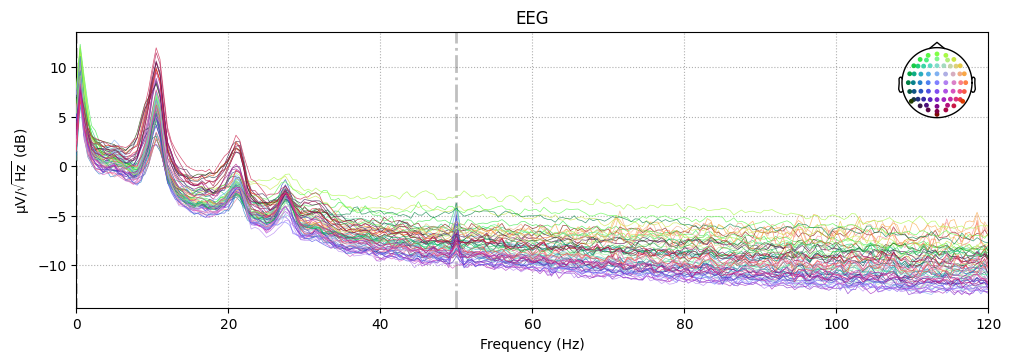

In [6]:
raw_resting.plot(duration=5, n_channels=30)
raw_resting.compute_psd(fmin=0, fmax=120).plot(average=False, picks="data", exclude='bads', amplitude='false')

We can see there is a small spike at 50Hz, which is *line noise*. So let's remove it! I'll use two methods:
- Notch filter (part of MNE)
- ZapLine (requires MEEGKit)

In [7]:
raw_resting_notch = raw_resting.copy().notch_filter(freqs=50)
zapline_output, _ = dss.dss_line_iter(raw_resting.get_data().T, 50, raw_resting.info['sfreq'], nfft=400)
raw_resting_zapline = mne.io.RawArray(zapline_output.T, raw_resting.info)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.4s finished


Power of components removed by DSS: 0.00
Iteration 0 score: -5.91416379593561e-16
Creating RawArray with float64 data, n_channels=64, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.


So right off the bat, it's clear that ZapLine takes quite a bit longer to run than a notch filter does. That's because it's looking for a spatial filter to remove line noise, rather than applying a notch filter evenly to every single channel in the montage. It also really needs to not have bad channels included, or it gets stuck in an endless loop. Let's look at the difference between the two methods.

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


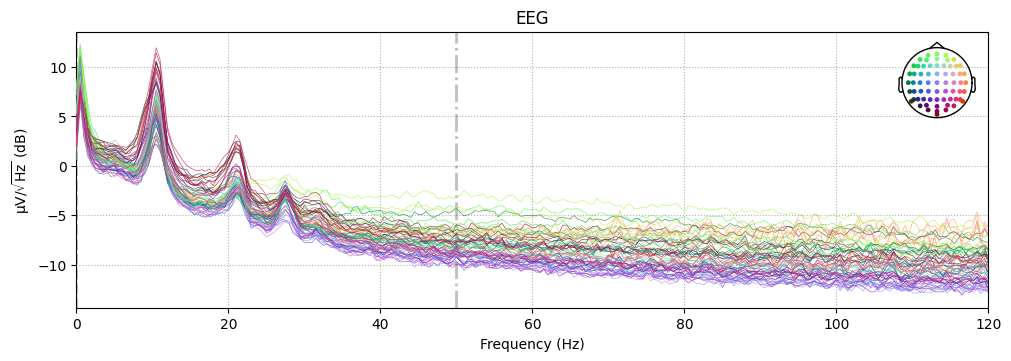

In [8]:
raw_resting_notch.compute_psd(fmin=0, fmax=120).plot(average=False, picks="data", exclude='bads', amplitude='false')
raw_resting_zapline.compute_psd(fmin=0, fmax=120).plot(average=False, picks="data", exclude='bads', amplitude='false')

Okay, so from here on out, I'm going to be working with `raw_resting_zapline`. Now, let's apply a lowpass filter and a highpass filter. In MNE, we can do this simultaneously. I will use a highpass cutoff of 1Hz and a lowpass cutoff of 100Hz.

In [9]:
raw_resting_zapline = raw_resting_zapline.filter(l_freq=1, h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3381 samples (3.302 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.4s finished


Let's visualize this:

Effective window size : 2.000 (s)


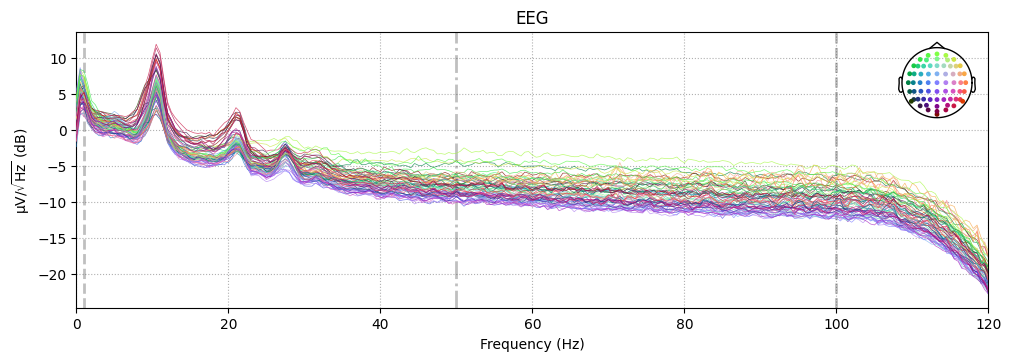

In [10]:
raw_resting_zapline.compute_psd(fmin=0, fmax=120).plot(average=False, picks="data", exclude='bads', amplitude='false')

Lastly, we want to remove EOG artifacts. Because this EEG system doesn't have dedicated EOG channels, we'll be using ICA, which is data-driven and does not need an external measure of electromuscular activity.

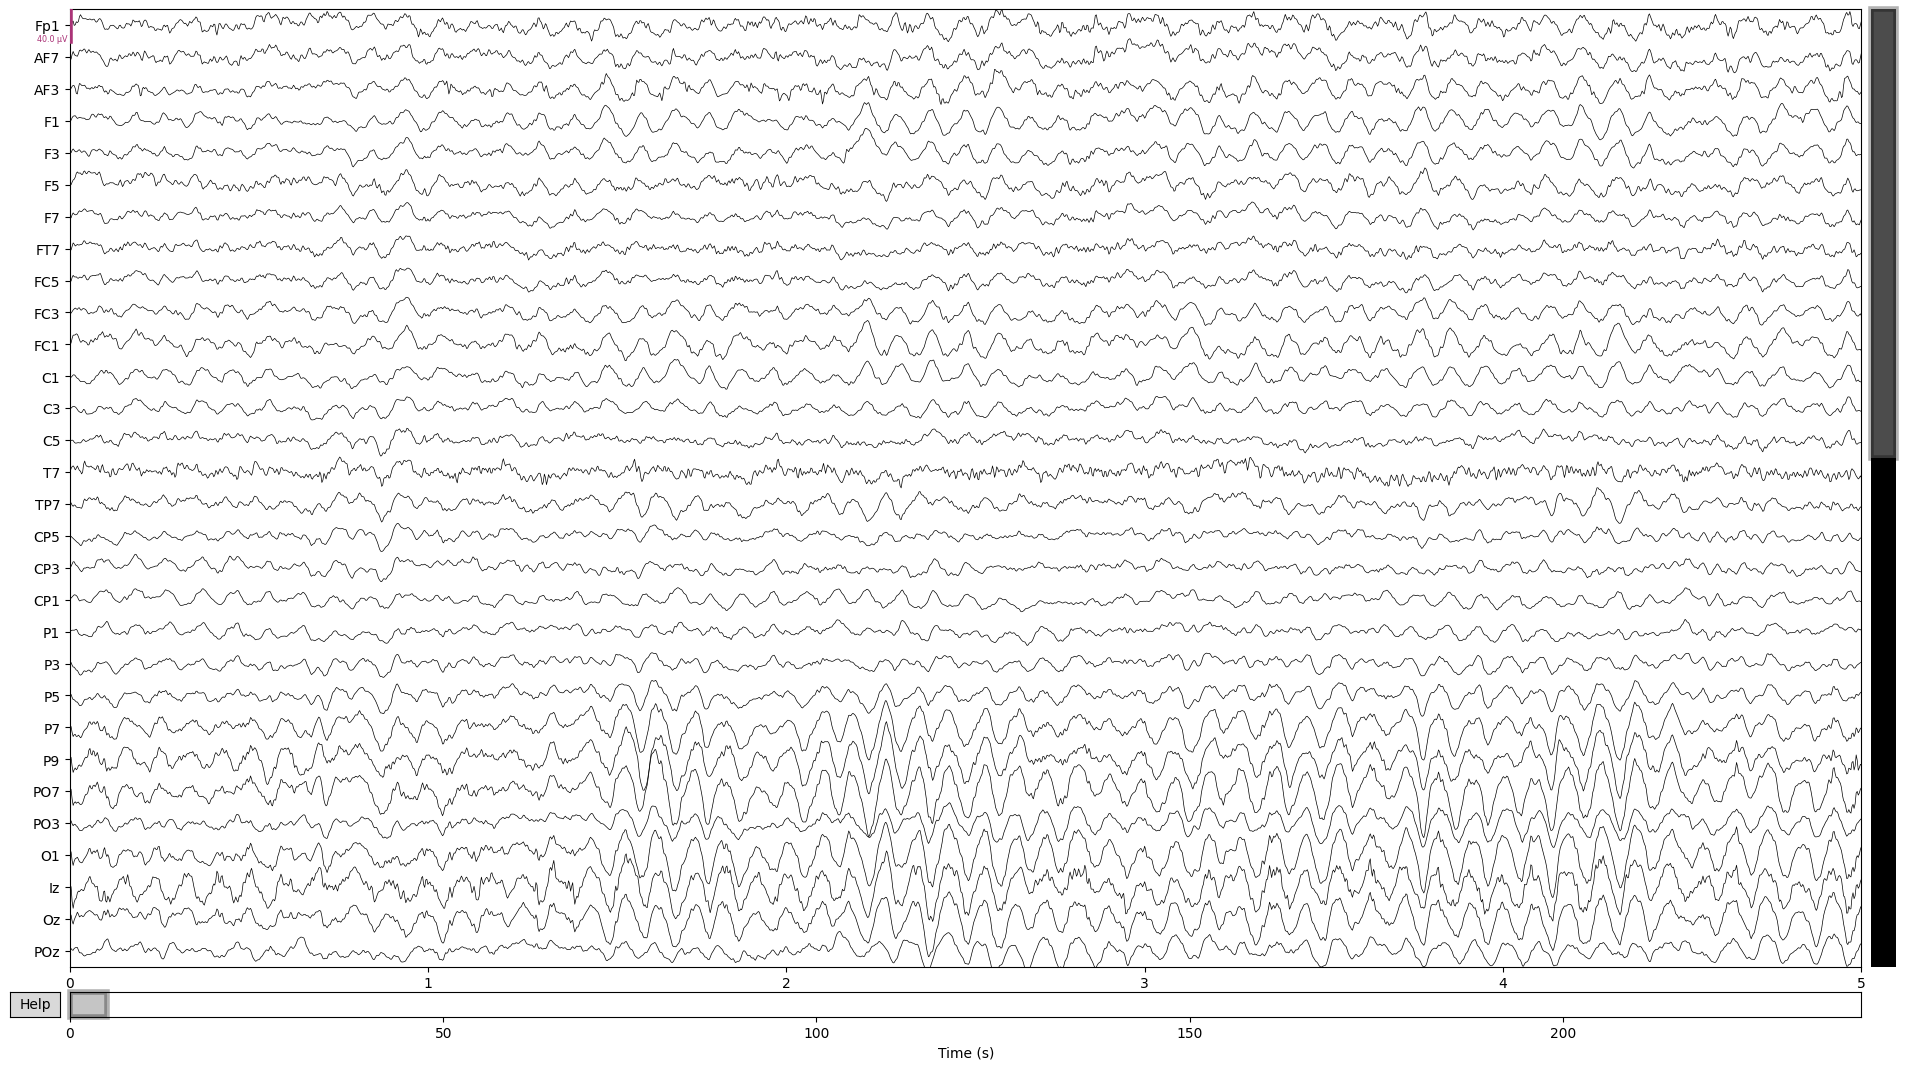

In [11]:
raw_resting_zapline.plot(duration=5, n_channels=30)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.4s.


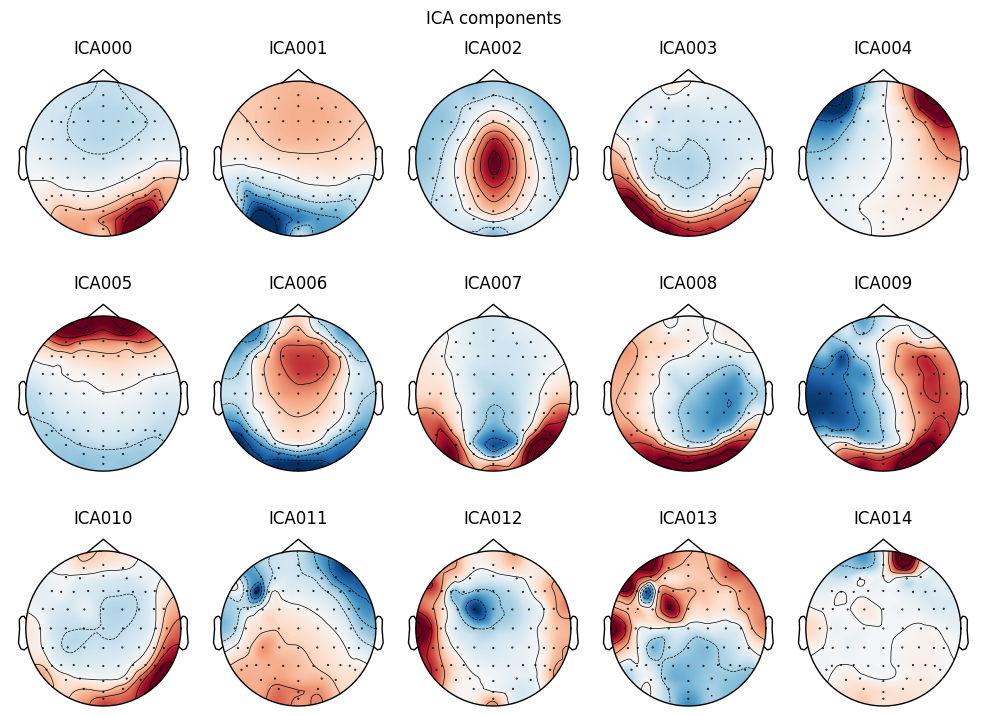

In [12]:
ica = mne.preprocessing.ICA(n_components=15, method='picard', max_iter='auto')
ica.fit(raw_resting_zapline, decim=3, reject=dict(mag=5e-12))
ica.plot_components()

In [13]:
ica.plot_properties(raw_resting_zapline, picks=4)
ica.plot_properties(raw_resting_zapline, picks=5)

Creating RawArray with float64 data, n_channels=64, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=64, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>]

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


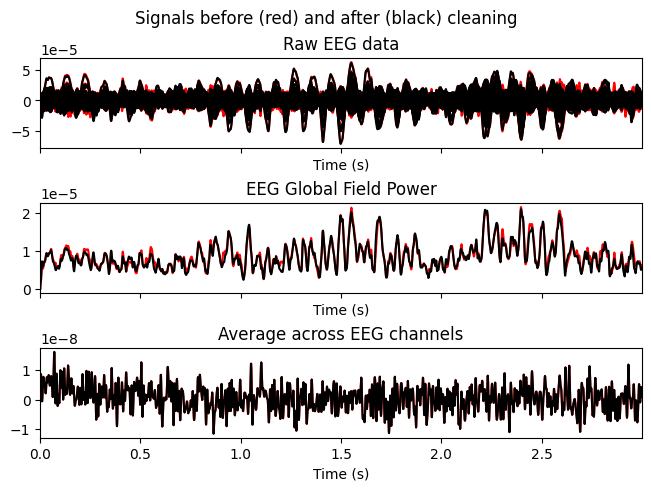

In [14]:
ica.plot_overlay(raw_resting_zapline, exclude=[0, 1, 3])
ica.plot_overlay(raw_resting_zapline, exclude=[4, 5])

Lastly, we'll apply these ICA components.

In [15]:
ica.exclude = [4, 5]
ica.apply(raw_resting_zapline)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


<RawArray | 64 x 245760 (240.0 s), ~120.1 MB, data loaded>

Here, we're going to do three sets of analyses:
- Compute the PSD slope
- Compute spectral power in several frequency bands
- Compute sensor-space coherence (functional connectivity)

### PSD slope

For the PSD, there are two slightly different approaches. We can simply compute a linear regression predicting log-power by log-frequency, or we can apply the FOOOF algorithm. I'll do both approaches here.

First, we need to extract the spectrum and compute its mean across the scalp. Then we can run both methods: a log-log regression, and FOOOF.

Effective window size : 2.000 (s)


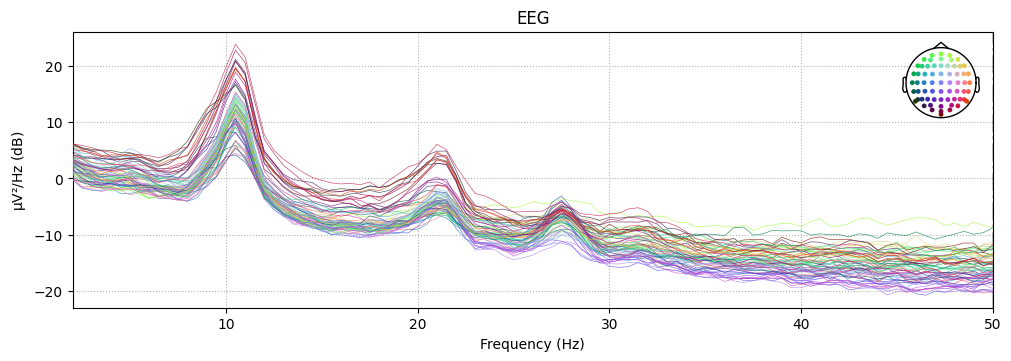

In [16]:
rest_spectrum = raw_resting_zapline.compute_psd(fmin=2, fmax=50)
freqs = rest_spectrum.freqs
powers = rest_spectrum.get_data()
mean_powers = np.mean(powers, 0)
rest_spectrum.plot()

In [17]:
psd_slope = np.polyfit(np.log10(freqs), np.log10(mean_powers), 1)
print(psd_slope)

[ -1.82181022 -10.33245102]


In [18]:
x = np.linspace(2,50,99)
y = np.log10(x) * psd_slope[0] + psd_slope[1]
psd_slope
plt.figure()
plt.plot(freqs, np.log10(mean_powers))
plt.plot(x,y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('log(Power)')
# plt.axline((0, psd_slope[1]), psd_slope[0])
plt.show()

This gives us a slope of -1.822. How about FOOOF?

In [19]:
fm = fooof.FOOOF()
freq_range = [2, 50]
fm.fit(freqs, mean_powers, freq_range)
fm.print_results()
fm.plot()


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

This gives us an exponent of 1.538 (since this is exponential decay, this is equivalent to a log-slope of -1.538). So they're similar, but not identical.

### Spectral band power

Next up, let's look at spectral power. There's a couple of ways of handling this, but they all start by looking in a specific band. We'll use the bands from the Autism Biomarkers Consortium for Clinical Trials (ABC-CT; Webb et al., 2023):
- Alpha: 6-13Hz
- Beta: 13-35Hz
- Gamma: 35-55Hz

Note that the gamma range includes the line noise frequency (50Hz), since these data were collected outside North America. It can be necessary to change these frequency boundaries to avoid line noise frequencies, so I altered that bound in practice. That also aligns with the span we used to compute the PSD slope.

In [80]:
fig, ax = plt.subplots()
rest_spectrum.plot(axes = ax)
ax.axvspan(6, 13, alpha=0.4, color='#009E73')
ax.axvspan(13, 35, alpha=0.4, color='#D55E00')
ax.axvspan(35, 50, alpha=0.4, color='#56B4E9')
plt.show()

In [81]:
alpha_freqs = raw_resting_zapline.compute_psd(fmin=6, fmax=13)
alpha_power = np.sum(np.mean(alpha_freqs.get_data(), 0)) / (13-6)
beta_freqs = raw_resting_zapline.compute_psd(fmin=13, fmax=35)
beta_power = np.sum(np.mean(beta_freqs.get_data(), 0)) / (35-13)
gamma_freqs = raw_resting_zapline.compute_psd(fmin=35, fmax=50)
gamma_power = np.sum(np.mean(gamma_freqs.get_data(), 0)) / (50-35)
print((alpha_power, beta_power, gamma_power))

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
(1.2944023321790193e-11, 4.361436284295174e-13, 7.547900901034207e-14)


Another way of doing this would have been to simply pull the parts out of `mean_powers` that corresponded to the correct frequencies, like:

```alpha_power = np.sum([mean_powers[i] for i in range(len(mean_powers)) if freqs[i] >= 6 and freqs[i] <= 13])```

To normalize this, we simply divide these frequencies by the sum across the full spectrum.

In [82]:
alpha_power_normed = alpha_power / np.sum(mean_powers)
beta_power_normed = beta_power / np.sum(mean_powers)
gamma_power_normed = gamma_power / np.sum(mean_powers)
print((alpha_power_normed, beta_power_normed, gamma_power_normed))

(0.11501896163245962, 0.0038755173733446627, 0.0006706969715360441)


### Functional connectivity

Next up, sensor-space coherence! We're going to compute this using the `spectral_connectivity` function from `mne_connectivity`. Here, I'm defining a set of frequency bands including delta (1-4Hz), theta (4-6Hz), alpha (6-13Hz), beta (13-35Hz), and gamma (35-55Hz). Other options include:
- `method='coh'` refers to using coherence
- `mode='multitaper'` is using the multitaper method of spectral decomposition, rather than a Fourier analysis

Before running this, I need to separate my signal into equal-length epochs using `make_fixed_length_epochs`. I'm using relatively long ones to resolve the full range of frequencies that I care about here.

In [37]:
fmins = (1, 4, 6, 13, 35)
fmaxs = (4, 6, 13, 35, 55)
raw_resting_divided = mne.make_fixed_length_epochs(raw_resting_zapline, duration=20)
resting_spec_connect = mnec.spectral_connectivity_epochs(
    raw_resting_divided,
    sfreq=raw_resting_zapline.info['sfreq'],
    method='coh',
    mode='multitaper',
    fmin=fmins,
    fmax=fmaxs,
    faverage=True
)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=0.000s..19.999s for estimation (20480 points)
    computing connectivity for the bands:
     band 1: 1.0Hz..4.0Hz (61 points)
     band 2: 4.0Hz..6.0Hz (41 points)
     band 3: 6.0Hz..13.0Hz (141 points)
     band 4: 13.0Hz..35.0Hz (441 points)
     band 5: 35.0Hz..55.0Hz (401 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectra

To visualize this, we can use `mne_connectivity.viz.plot_sensors_connectivity`. This is a bit tricky, depending on the backed you're using. I am using `PyQt5` and `pyvista`, so make sure you have the right dependencies installed, or this won't work! Also, keep in mind that this function defaults to only showing connectivities between sensors that are at least 5cm apart, because closer than that, and you're basically measuring the same signal anyway.

In [38]:
con = resting_spec_connect.get_data(output='dense')[:,:,0]
mnec.viz.plot_sensors_connectivity(raw_resting_divided.info, con, n_con=50)

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with:
pip install qdarkstyle



## Stimulus-based analyses

For this, we're going to use a different dataset. This one is from an auditory oddball task involving isochronous stimuli. Unlike the previous dataset, which was downloaded in full, properly-formatted form from OpenNeuro, this one was obtained from the SPM website (https://www.fil.ion.ucl.ac.uk/spm/data/eeg_mmn/), and will be imported manually. It's also an opportunity to show another way of getting data into MNE!

We'll start by importing the raw data file itself.

In [3]:
raw_erp = mne.io.read_raw_eeglab('./data/MMN_Practice.set')

C:\Users\framnr1\AppData\Local\Temp\ipykernel_12512\2041884725.py:1: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_erp = mne.io.read_raw_eeglab('./data/MMN_Practice.set')


Now, if you look at the `info` part of this raw file, you'll notice that it's missing some important information, specifically the channel locations. Luckily for us, this was recorded on a system that we have a montage for within MNE (128-channel Biosemi). So let's just load that in!

In [4]:
raw_erp.set_montage('biosemi128')

<RawEEGLAB | MMN_Practice.set, 128 x 468480 (915.0 s), ~457.7 MB, data loaded>

From here, we're going to run through the exact same cleaning steps as before.

Effective window size : 4.000 (s)


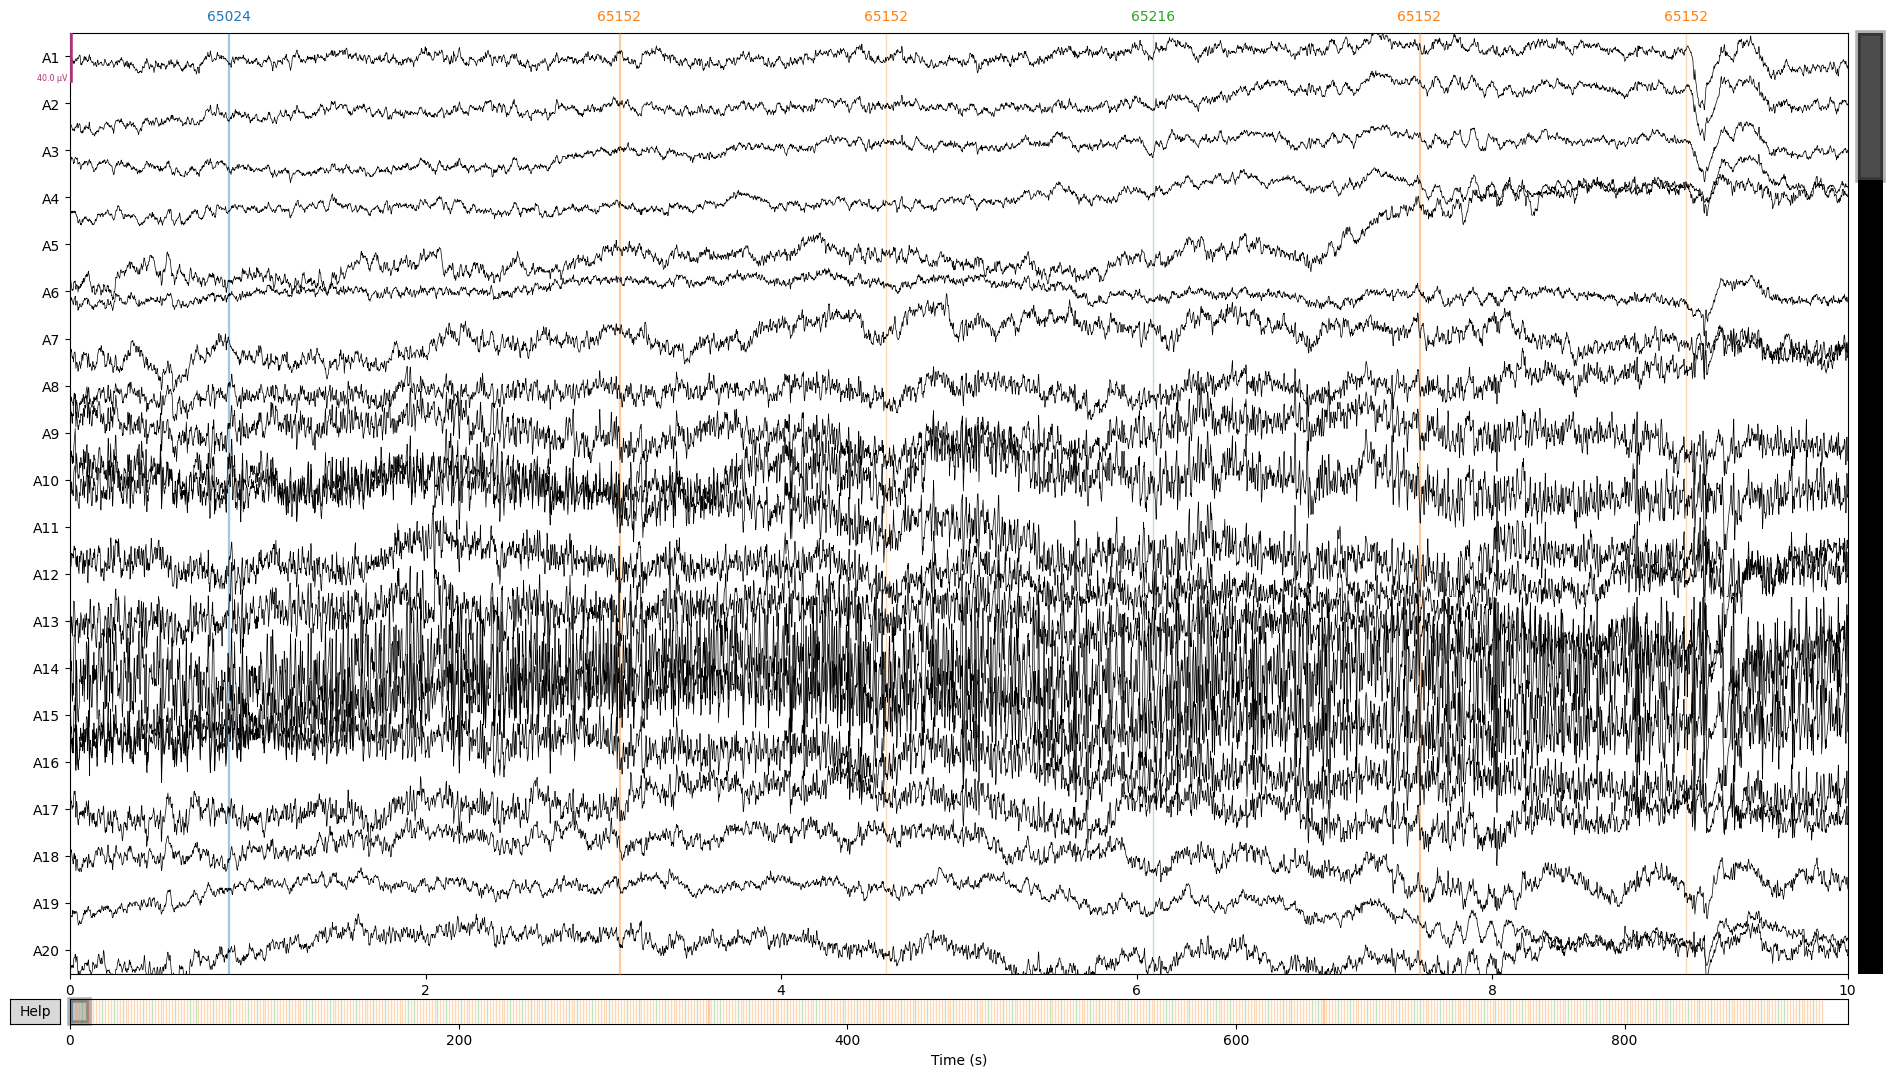

In [52]:
raw_erp.compute_psd(fmin=0, fmax=120).plot(average=False, picks="data", exclude='bads', amplitude='false')
raw_erp.plot()

Now, for this file it's pretty clear that there are some channel issues. That chunk of channels with labels starting with A are all the parietal/occipital region of the scalp, where it's likelier that hair interfered with making good contact with the scalp. `B25` is over on the far right side of the head, over near the right ear. That one also looks noticeably different than the others, and like something that will actually be harder to manage. In fact, the original version of this analysis marked `A14` as bad rather than `B25`, and subsequently removed it from the analysis. To some extent, this is a judgment call, and partly driven by considerations like the possibility of recovering signal using interpolation; since `A14` is in the middle of a group of electrodes with noise, it's like that it isn't recoverable, while `B25` is isolated among electrodes with valid data, so is more likely to be fixable. The analyses here also (mostly) focus on frontocentral activity, which reduces the concern from noisy data in parietal and occipital regions, where `A14` is located. But part of this is showing you how to handle bad channels, so I'll mark `B25` as a "bad" channel before we go any farther.

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 127 sensor positions
Interpolating 1 sensors
Using matplotlib as 2D backend.


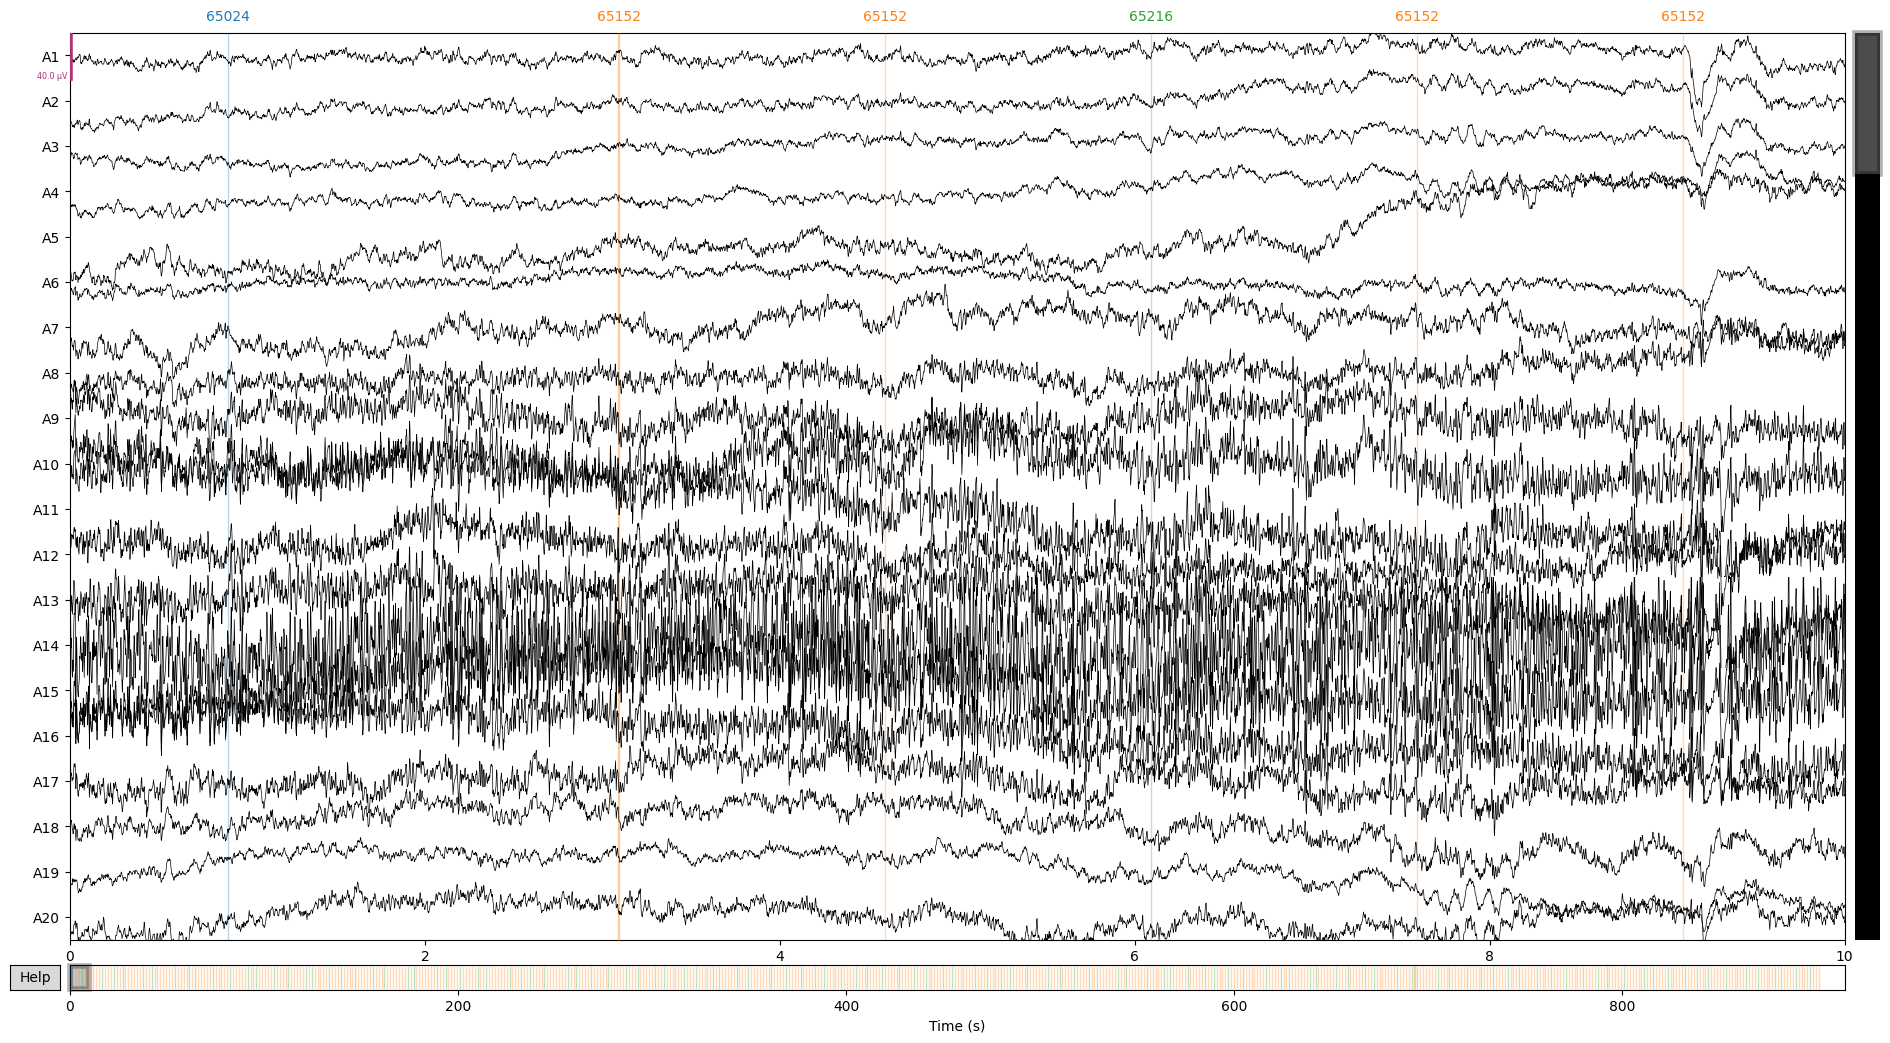

In [5]:
raw_erp.info['bads'] = ['B25']
raw_erp = raw_erp.interpolate_bads()
raw_erp.plot()

If you scroll down to look at B25, while before it looked pretty choppy, now it looks great! MNE uses an interpolation method called a spherical spline, where it's interpolating the data at the bad electrode(s) based on the behavior of their neighbors. This is also why a whole cluster of bad channels is a lot harder to deal with, and indicates something like too much hair for consistent contact, than a couple of isolated ones. In those cases, it's worth thinking carefully about how much of an impact that will have on your broader analysis, and that's something that often requires knowledge of the participants themselves. For instance, recording data with young children is almost always a lot noisier than with adults.

In [6]:
erp_zap, _ = dss.dss_line_iter(raw_erp.get_data().T, 50, raw_erp.info['sfreq'], nfft=400)
raw_erp_filt = mne.io.RawArray(erp_zap.T, raw_erp.info).filter(l_freq=1, h_freq=100)

Power of components removed by DSS: 0.00
Iteration 0 score: 4.597693729246011e-15
Power of components removed by DSS: 0.00
Iteration 1 score: -8.678036309943242e-16
Creating RawArray with float64 data, n_channels=128, n_times=468480
    Range : 0 ... 468479 =      0.000 ...   914.998 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    2.2s finished


Effective window size : 4.000 (s)


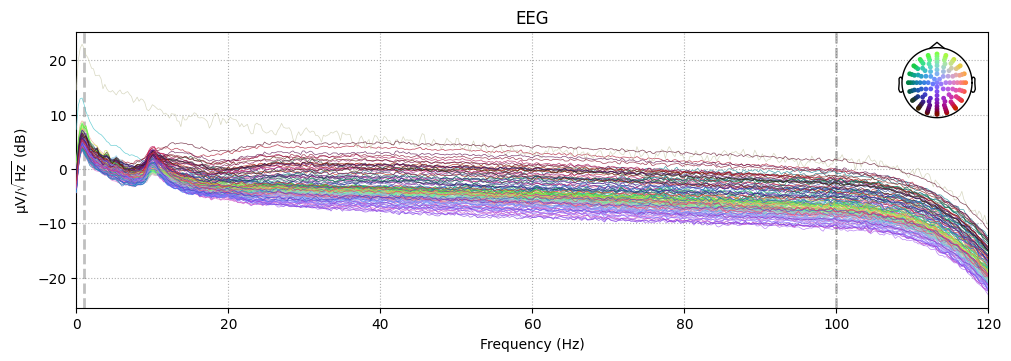

In [55]:
raw_erp_filt.compute_psd(fmin=0, fmax=120).plot(average=False, picks="data", exclude='bads', amplitude='false')

Fitting ICA to data using 128 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 11.2s.
Creating RawArray with float64 data, n_channels=15, n_times=468480
    Range : 0 ... 468479 =      0.000 ...   914.998 secs
Ready.


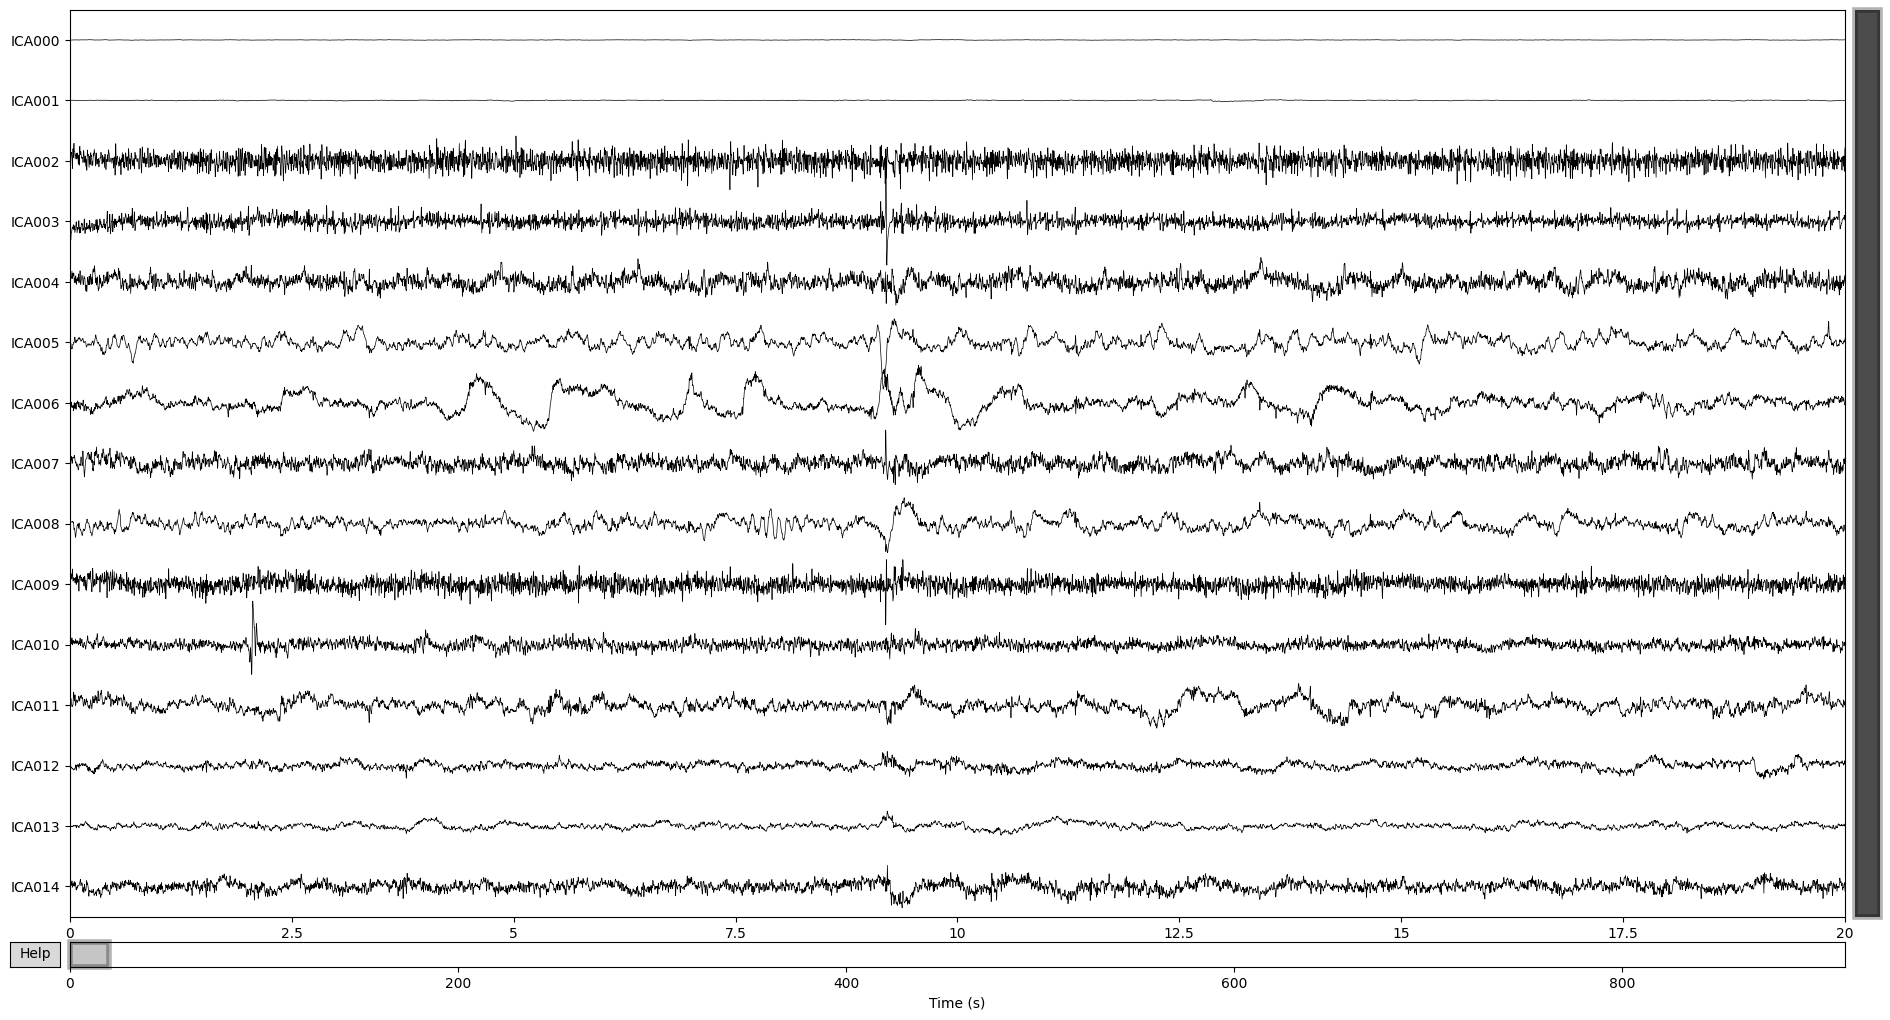

In [7]:
ica_erp = mne.preprocessing.ICA(n_components=15, method='picard', max_iter='auto')
ica_erp.fit(raw_erp_filt, decim=3, reject=dict(mag=5e-12))
ica_erp.plot_components()
ica_erp.plot_sources(raw_erp_filt)

In [57]:
ica_erp.plot_properties(raw_erp_filt, picks=6)
ica_erp.plot_properties(raw_erp_filt, picks=11)

Creating RawArray with float64 data, n_channels=128, n_times=467968
    Range : 0 ... 467967 =      0.000 ...   913.998 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
457 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=128, n_times=467968
    Range : 0 ... 467967 =      0.000 ...   913.998 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
457 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>]

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components


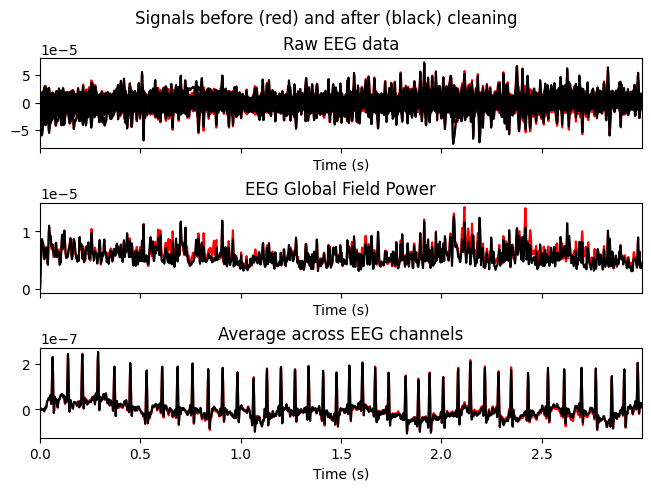

In [58]:
ica_erp.plot_overlay(raw_erp_filt, exclude=[6,11])

In [8]:
ica_erp.exclude = [6, 11]
ica_erp.apply(raw_erp_filt)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 128 PCA components


<RawArray | 128 x 468480 (915.0 s), ~457.7 MB, data loaded>

### Induced ERP -- beta synchronization

For this, we're going to be looking at a *time-frequency analysis*. This is look at changes in a particularly oscillatory frequency over time. To do that, we need to build a set of *epochs*, or windows built around events. The events in this dataset happen at relatively long intervals (1.5s, or 768 samples), so for this part of the analysis, we need similarly long epochs.

First, we need to identify the events we will be building this analysis around. Let's look at the events in this dataset. First, we need to load them in.

In [9]:
erp_events = mne.events_from_annotations(raw_erp)

Used Annotations descriptions: ['65024', '65152', '65216']


Now, if we associate these events with the EEG dataset, we can build epochs around them! Specifically, we want to build epochs around every event labeled as 65152 (standard) or 65216 (deviant). This distinction will be more relevant later on, but for now, we'll consider them all to be the same thing, so let's build a new event list with everything labeled the same. We'll call this new event type (any onset, standard or deviant) something like 65001.

In [10]:
beta_events = (np.array([[x[0], x[1], 4] for x in erp_events[0] if x[2] == 2 or x[2] == 3]), {'Onset':4})

Now, let's build epochs! Given the time between stimuli, we're going to have a pretty broad range here. Let's do, say, from 1 second before the stimulus to 2 seconds after.

In [11]:
beta_epochs = mne.Epochs(
    raw_erp_filt,
    beta_events[0],
    event_id=beta_events[1],
    tmin=-1,
    tmax=2,
    baseline=(-1,-0.5),
    reject={'eeg':1e-3}
)

Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


Now, we need to analyze frequencies in the beta range. Following after Meijer, te Woerd, & Praamstra (2016), we'll use a frontal region of interest which is a slightly broader version of the ROI we'll use for the ERP analysis later on. This includes channels:
- C32
- C27
- C19
- C14
- C10
- D4
- C26
- C20
- C13
- C4
- D3
- C25
- C21
- C12
- C3
- C24
- C22
- C11

We can compute the indices of these (what the `picks` argument wants) pretty simply using 

In [12]:
beta_elecs = ['C32', 'C27', 'C19', 'C14', 'C10', 'D4', 'C26', 'C20', 'C13', 'C4', 'D3', 'C25', 'C21', 'C12', 'C3', 'C24', 'C22', 'C11']
beta_ix = mne.pick_channels(beta_epochs.info["ch_names"], include=beta_elecs)

freqs=np.logspace(*np.log10([13,30]), num=10)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(
    beta_epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    n_jobs=None,
    picks=beta_ix
)

Using data from preloaded Raw for 600 events and 1537 original time points ...
    Rejecting  epoch based on EEG : ['D3']
    Rejecting  epoch based on EEG : ['D3']


C:\Users\framnr1\AppData\Local\Temp\ipykernel_12512\1225082879.py:2: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  beta_ix = mne.pick_channels(beta_epochs.info["ch_names"], include=beta_elecs)


    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecti

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.4s finished


In [14]:
beta_y = np.mean(np.sum(power.data, 1) / (30-13), 0)
beta_x = np.linspace(-1,2,power.data.shape[2])
plt.figure()
plt.plot(beta_x[20:len(beta_x)-20], beta_y[20:len(beta_y)-20], color='black')
plt.axvline(x=0, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=1.5, ymin=0, ymax=1, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Beta power')
plt.show()

### Evoked ERP -- mismatch negativity

For this one, we DO care about the difference between standard and deviant tones. In particular, we're going to look at the evoked waveform in each of them, and the difference between them. So let's build a new set of epochs!

For this analysis, it's actually helpful to use a pretty stringent lowpass filter. We are looking for large-scale changes in scalp voltage, so here we're using a lowpass filter to *smooth* the data, rather than remove ambient EM artifactual noise. That makes it part of the analysis itself, rather than part of data cleaning.

In [18]:
mmn_filt = raw_erp_filt.copy().filter(l_freq=1, h_freq=20)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    1.8s finished


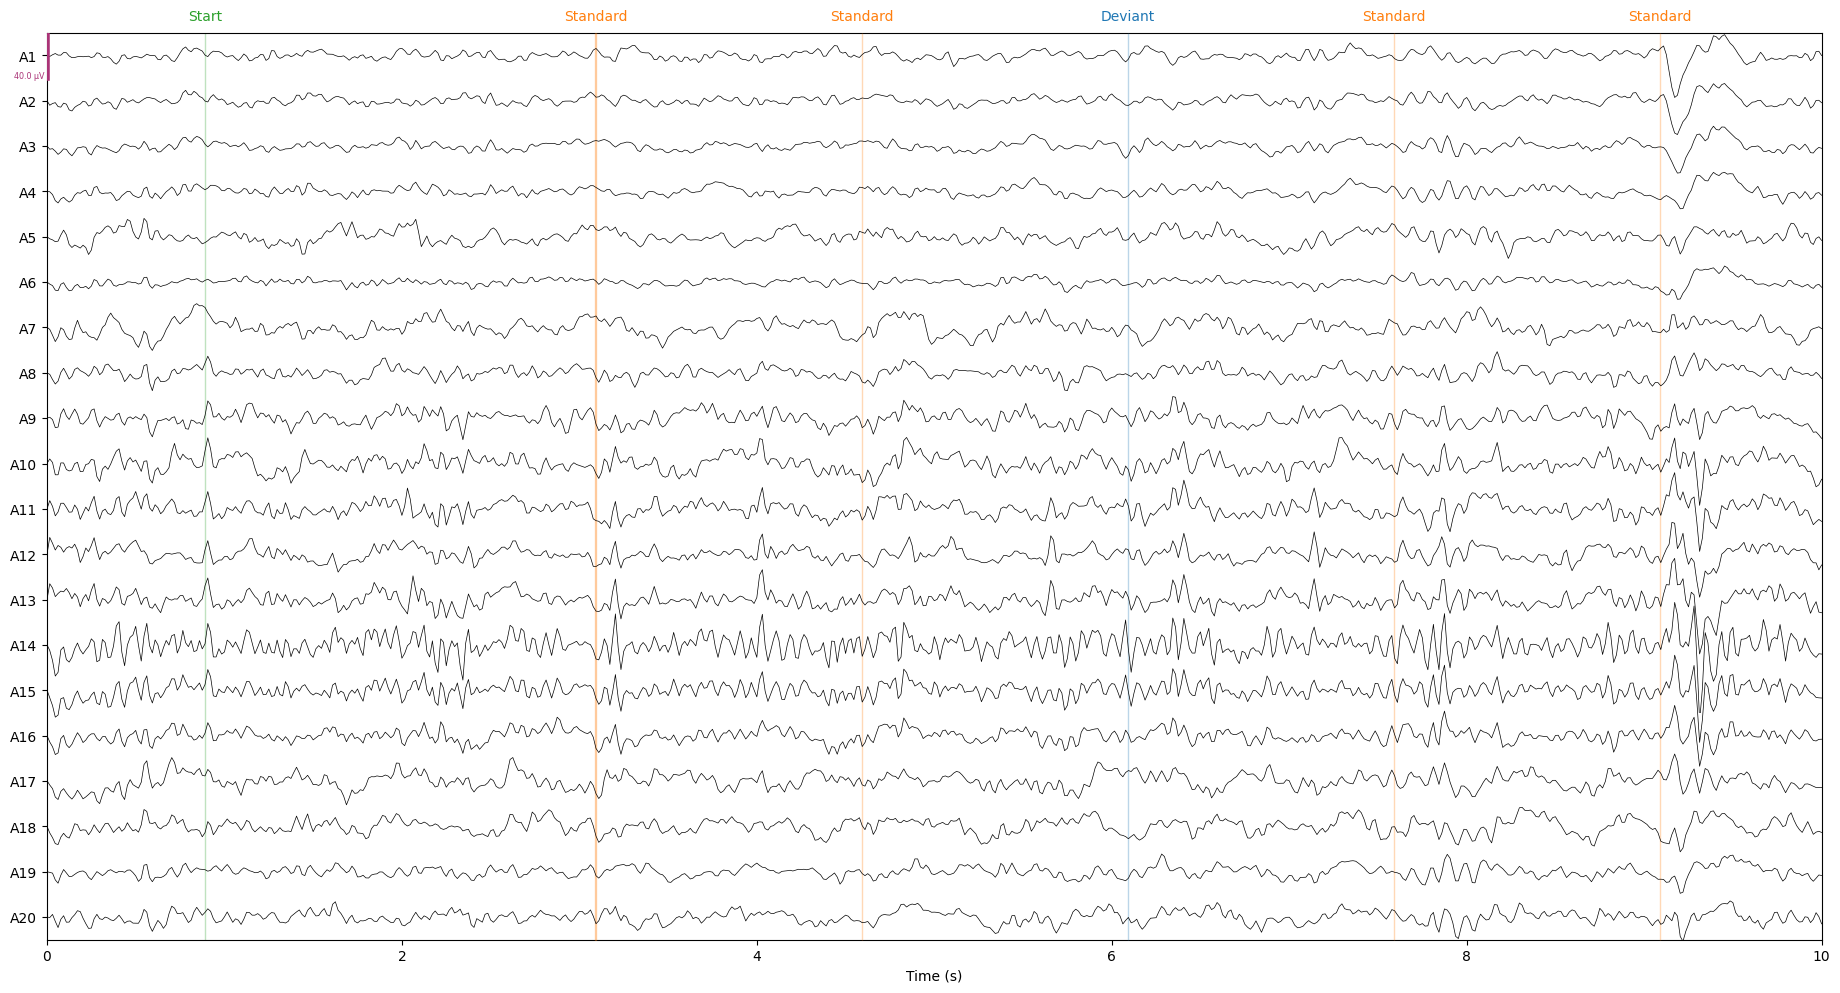

In [19]:
mmn_ann = mne.annotations_from_events(erp_events[0], event_desc={1:'Start', 2:'Standard', 3:'Deviant'}, sfreq=mmn_filt.info['sfreq'])
mmn_filt.set_annotations(mmn_ann)
mmn_filt.plot(show_scrollbars=False)

In [20]:
mmn_epochs = mne.Epochs(
    mmn_filt,
    erp_events[0],
    event_id={'Start':1, 'Standard':2, 'Deviant':3},
    tmin=-.1,
    tmax=0.5,
    baseline=(-.1,0),
    reject={'eeg':1e-3}
)

Not setting metadata
601 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


Now, we're going to compute the average waveform in each condition. For this, we will be focusing on the frontocentral region which, in this particular scheme, could be this subset of channels:
- C21
- C25
- C12
- C20
- C26
- C13
- C19
- C27
- C14

This is pretty concentrated, and we're throwing out most of the cap by doing this. But I'll get to that in a minute.

In [21]:
mmn_standard = mmn_epochs['Standard'].average()
mmn_deviant = mmn_epochs['Deviant'].average()

    Rejecting  epoch based on EEG : ['D3']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']


First, let's take a look at what the entire scalp looks like. These are called *butterfly plots* because they tend to look like butterfly wings.

No projector specified for this dataset. Please consider the method self.add_proj.


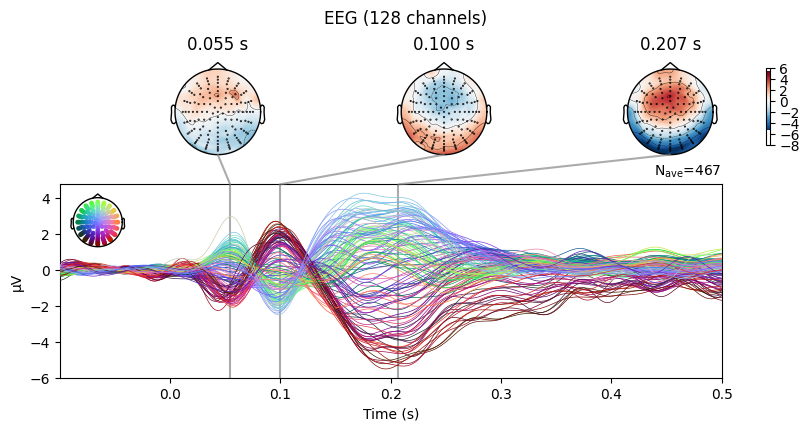

Channels marked as bad:
none


In [25]:
mmn_standard.plot_joint()
# mmn_deviant.plot_joint()

You can see we have a frontocentral region that's negative around 100ms after the stimulus in both conditions, then positive about 200-230ms after. That's a pretty typical response to this sort of auditory stimulus. We're interested in how these two waveforms compare.

In [71]:
fc_elecs = ['C21', 'C25', 'C12', 'C20', 'C26', 'C13', 'C19', 'C27', 'C14']
fc_ix = mne.pick_channels(mmn_standard.info["ch_names"], include=fc_elecs)
roi_standard = mne.channels.combine_channels(mmn_standard, {'FC':fc_ix}, method="mean")
roi_deviant = mne.channels.combine_channels(mmn_deviant, {'FC':fc_ix}, method="mean")

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


C:\Users\framnr1\AppData\Local\Temp\ipykernel_8808\1009701127.py:2: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  fc_ix = mne.pick_channels(mmn_standard.info["ch_names"], include=fc_elecs)


In [72]:
evokeds = dict(Standard=roi_standard, Deviant=roi_deviant)
mne.viz.plot_compare_evokeds(evokeds)

C:\Users\framnr1\AppData\Local\Temp\ipykernel_8808\3396152473.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds)


[<Figure size 800x600 with 1 Axes>]

### Topographic EEG

For this, we're going to look at changes in the overall *topography* of activity. This means running a test called a *topographic ANOVA*, which is really a permutation test of a measure called the *global dissimilarity*. What we're looking for are windows within the EEG signal that have the same topography, although it can vary in strength. And unfortunately, MNE really isn't set up to do this kind of analysis natively. But I'll show you the math behind the metric and point to another software package that does it very well!

The global dissimilarity is the square root of the mean of the squared differences among the potentials at each electrode, scaled by the instantaneous global field power (which is itself the standard deviation of potentials among electrodes). Let's write a function to compute it.

In [27]:
def global_diss(topo1, topo2):
    """Computes global dissimilarity between two topographies."""
    diss = np.mean((topo1/np.std(topo1) - topo2/np.std(topo2))**2)**(1/2)
    return diss

Now, we can compute the dissimilarity between maps! This is used to separate EEG signals into sections characterized by topographically stable components that are just changing power. For instance, let's look at a butterfly plot of the standard stimulus evoked potential, including the global field power.

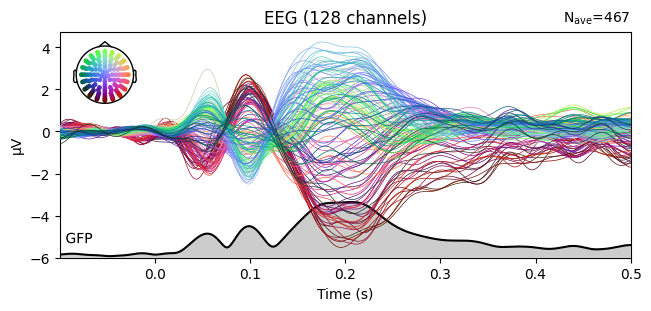

In [22]:
mmn_standard.plot(gfp=True, spatial_colors=True)

See that section around 0.1s? Let's plot its topography. That should be about 0.2 seconds from the beginning of the stimulus, which is about 100 samples in.

In [30]:
mne.viz.plot_topomap(
    mmn_standard.data[:,100],
    mmn_standard.info
)

(<matplotlib.image.AxesImage at 0x200b8cb3dc0>,
 <matplotlib.contour.QuadContourSet at 0x200b8cb2230>)

Now, let's compare that topography to the topography in the immediately preceding sample.

In [31]:
mne.viz.plot_topomap(
    mmn_standard.data[:,99],
    mmn_standard.info
)
global_diss(mmn_standard.data[:,100], mmn_standard.data[:,99])

0.025068349066931356

That's very, very low. Which we'd expect; they're extremely similar! How about the ones a tenth of a second later, around sample 150?

In [33]:
mne.viz.plot_topomap(
    mmn_standard.data[:,150],
    mmn_standard.info
)
global_diss(mmn_standard.data[:,100], mmn_standard.data[:,150])

1.9741943926093395

That's quite high! In fact, it's almost at 2, which means it's basically the same pattern of electrodes, but with the polarities reversed. You can see that happening in the butterfly plot, too, since the dark red lines that were positive around 0.1s switch to negative by 0.2, while the blue lines went from negative to positive.

Topographic ERP analysis uses the global dissimilarity to separate the EEG signal into segments. We'd need to write standalone code to do that in MNE, so I'll leave that alone for now, but if you want a tutorial in how it works (and how to run it in Cartool, which is a standalone program designed for exactly this sort of thing), look at this article: https://link.springer.com/article/10.1007/s10548-008-0054-5.